In [ ]:
'''
Panagiotis Christakakis

Comments: For running different feature extraction algorithm
          and different clustering technique the code changes
          only a little bit, thats why I only upload one .py
          file. BRISK is in comments (#) and from the clustering
          techniques that didn't work I keep DBSCAN commented too
          as an example.
'''

In [15]:
#Install packages

In [14]:
pip install opencv-contrib-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 54 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [12]:
pip install opencv-python==3.4.2.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 57.8 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66


In [8]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
#Import libraries
import splitfolders
import cv2
import os
from sklearn.cluster import MiniBatchKMeans #KMeans
import numpy as np
#import secondary functions that will be used very frequent
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Convert Categorical Data For Scikit-Learn
from sklearn import preprocessing

In [19]:
#Download dataset from Kaggle and unzip it
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anirudhg15/mammals-classification
! unzip mammals-classification.zip

 97% 492M/508M [00:03<00:00, 176MB/s]
100% 508M/508M [00:03<00:00, 157MB/s]
Archive:  mammals-classification.zip
  inflating: mammals/bear/00000000.jpg  
  inflating: mammals/bear/00000001.jpg  
  inflating: mammals/bear/00000002.JPG  
  inflating: mammals/bear/00000003.jpg  
  inflating: mammals/bear/00000004.JPG  
  inflating: mammals/bear/00000005.jpg  
  inflating: mammals/bear/00000006.jpg  
  inflating: mammals/bear/00000007.jpg  
  inflating: mammals/bear/00000008.jpg  
  inflating: mammals/bear/00000009.jpg  
  inflating: mammals/bear/00000010.jpg  
  inflating: mammals/bear/00000011.jpg  
  inflating: mammals/bear/00000012.JPG  
  inflating: mammals/bear/00000013.jpg  
  inflating: mammals/bear/00000014.jpg  
  inflating: mammals/bear/00000015.jpg  
  inflating: mammals/bear/00000016.jpg  
  inflating: mammals/bear/00000017.jpg  
  inflating: mammals/bear/00000018.jpg  
  inflating: mammals/bear/00000019.jpg  
  inflating: mammals/bear/00000020.jpg  
  inflating: mammals/bear/

In [20]:
#Splitting the dataset into train and test (80%-20% ratio)
input_folder = "/content/mammals"
output = "/content/train-test-mamamals"
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, 0, .2))

Copying files: 830 files [00:02, 343.49 files/s]


In [21]:
#Declare functions that will use later in our main code

# return a dictionary that holds all images category by category.
def load_images_from_folder(folder, inputImageSize ):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            img = cv2.imread(path + "/" + cat)
            #print(' .. parsing image', cat)
            if img is not None:
                # grayscale it
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #resize it, if necessary
                img = cv2.resize(img, (inputImageSize[0], inputImageSize[1]))

                category.append(img)
        images[filename] = category
        print(' . Finished parsing images. What is next?')
    return images

# Creates descriptors using an approach of your choise. e.g. ORB, SIFT, SURF, FREAK, MOPS,etc
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds the descriptors but this is seperated class by class
def detector_features(images):
    print(' . start detecting points and calculating features for a given image set')
    detector_vectors = {}
    descriptor_list = []

    #Using SIFT
    detectorToUse = cv2.xfeatures2d.SIFT_create()

    #Using BRISK
    #detectorToUse = cv2.BRISK_create()

    for nameOfCategory, availableImages in images.items():
        features = []
        for img in availableImages: # reminder: val
            kp, des = detectorToUse.detectAndCompute(img, None)

            descriptor_list.extend(des)
            features.append(des)
        detector_vectors[nameOfCategory] = features
        print(' . finished detecting points and calculating features for a given image set')
    return [descriptor_list, detector_vectors] # be aware of the []! this is ONE output as a list

# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeansVisualWordsCreation(k, descriptor_list):
    print(' . calculating central points for the existing feature values.')
    #kmeansModel = KMeans(n_clusters = k, n_init=10)
    batchSize = np.ceil(descriptor_list.__len__()/50).astype('int')
    #kmeansModel = DBSCAN(eps=0.5, min_samples=10)
    kmeansModel = MiniBatchKMeans(n_clusters=k, batch_size=batchSize, verbose=0)
    kmeansModel.fit(descriptor_list)
    visualWords = kmeansModel.cluster_centers_ # a.k.a. centers of reference
    print(' . done calculating central points for the given feature set.')
    return visualWords, kmeansModel

#Creation of the histograms. To create our each image by a histogram. We will create a vector of k values for each
# image. For each keypoints in an image, we will find the nearest center, defined using training set
# and increase by one its value
def mapFeatureValsToHistogram (DataFeaturesByClass, visualWords, TrainedKmeansModel):
    #depenting on the approach you may not need to use all inputs
    histogramsList = []
    targetClassList = []
    numberOfBinsPerHistogram = visualWords.shape[0]

    for categoryIdx, featureValues in DataFeaturesByClass.items():
        for tmpImageFeatures in featureValues: #yes, we check one by one the values in each image for all images
            tmpImageHistogram = np.zeros(numberOfBinsPerHistogram)
            tmpImageFeatures = tmpImageFeatures.astype(float)
            tmpIdx = list(TrainedKmeansModel.predict(tmpImageFeatures))
            clustervalue, visualWordMatchCounts = np.unique(tmpIdx, return_counts=True)
            tmpImageHistogram[clustervalue] = visualWordMatchCounts
            # do not forget to normalize the histogram values
            numberOfDetectedPointsInThisImage = tmpIdx.__len__()
            tmpImageHistogram = tmpImageHistogram/numberOfDetectedPointsInThisImage

            #now update the input and output coresponding lists
            histogramsList.append(tmpImageHistogram)
            targetClassList.append(categoryIdx)

    return histogramsList, targetClassList

In [22]:
#here we run the code

#define a fixed image size to work with
inputImageSize = [224, 224, 3] #define the FIXED size that CNN will have as input

In [23]:
#define the path to train and test files
TrainImagesFilePath ='/content/train-test-mamamals/train'
TestImagesFilePath = '/content/train-test-mamamals/test'

In [24]:
#load the train images
trainImages = load_images_from_folder(TrainImagesFilePath, inputImageSize)  # take all images category by category for train set

 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?


In [25]:
#calculate points and descriptor values per image
trainDataFeatures = detector_features(trainImages)
# Takes the descriptor list which is unordered one
TrainDescriptorList = trainDataFeatures[0]

 . start detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set


In [26]:
#create the central points for the histograms using k means.
#here we use a rule of the thumb to create the expected number of cluster centers
numberOfClasses = trainImages.__len__() #retrieve num of classes from dictionary
possibleNumOfCentersToUse = 10 * numberOfClasses
visualWords, TrainedKmeansModel = kmeansVisualWordsCreation(possibleNumOfCentersToUse, TrainDescriptorList)

 . calculating central points for the existing feature values.
 . done calculating central points for the given feature set.


In [27]:
# Takes the sift feature values that is seperated class by class for train data, we need this to calculate the histograms
trainBoVWFeatureVals = trainDataFeatures[1]

In [28]:
#create the train input train output format
trainHistogramsList, trainTargetsList = mapFeatureValsToHistogram(trainBoVWFeatureVals, visualWords, TrainedKmeansModel)
#X_train = np.asarray(trainHistogramsList)
#X_train = np.concatenate(trainHistogramsList, axis=0)
X_train = np.stack(trainHistogramsList, axis= 0)

In [29]:
# Create a label (category) encoder object
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(trainTargetsList)
#convert the categories from strings to names
y_train = labelEncoder.transform(trainTargetsList)

In [30]:
# train and evaluate the classifiers
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))


from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train, y_train)))


from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))

Accuracy of K-NN classifier on training set: 0.48
Accuracy of Decision Tree classifier on training set: 0.31
Accuracy of GNB classifier on training set: 0.46
Accuracy of SVM classifier on training set: 0.74


In [ ]:
#now run the same things on the test data.

#clear some space
del trainImages, trainBoVWFeatureVals, trainDataFeatures, TrainDescriptorList

In [33]:
#load the train images
testImages = load_images_from_folder(TestImagesFilePath, inputImageSize)  # take all images category by category for train set

 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?
 . Finished parsing images. What is next?


In [34]:
#calculate points and descriptor values per image
testDataFeatures = detector_features(testImages)

 . start detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set
 . finished detecting points and calculating features for a given image set


In [35]:
# Takes the sift feature values that is seperated class by class for train data, we need this to calculate the histograms
testBoVWFeatureVals = testDataFeatures[1]

In [36]:
#create the test input / test output format
testHistogramsList, testTargetsList = mapFeatureValsToHistogram(testBoVWFeatureVals, visualWords, TrainedKmeansModel)
X_test = np.array(testHistogramsList)
y_test = labelEncoder.transform(testTargetsList)

In [37]:
#classification tree
# predict outcomes for test data and calculate the test scores
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#calculate the scores
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
pre_train = precision_score(y_train, y_pred_train, average='macro')
pre_test = precision_score(y_test, y_pred_test, average='macro')
rec_train = recall_score(y_train, y_pred_train, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

#print the scores
print('')
print(' Printing performance scores:')
print('')

print('Accuracy scores of Decision Tree classifier are:',
      'train: {:.2f}'.format(acc_train), 'and test: {:.2f}.'.format(acc_test))
print('Precision scores of Decision Tree classifier are:',
      'train: {:.2f}'.format(pre_train), 'and test: {:.2f}.'.format(pre_test))
print('Recall scores of Decision Tree classifier are:',
      'train: {:.2f}'.format(rec_train), 'and test: {:.2f}.'.format(rec_test))
print('F1 scores of Decision Tree classifier are:',
      'train: {:.2f}'.format(f1_train), 'and test: {:.2f}.'.format(f1_test))
print('')

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train, y_pred_train))


 Printing performance scores:

Accuracy scores of Decision Tree classifier are: train: 0.31 and test: 0.19.
Precision scores of Decision Tree classifier are: train: 0.61 and test: 0.16.
Recall scores of Decision Tree classifier are: train: 0.30 and test: 0.18.
F1 scores of Decision Tree classifier are: train: 0.26 and test: 0.14.

              precision    recall  f1-score   support

           0       0.24      0.49      0.33        77
           1       0.67      0.18      0.28        79
           2       1.00      0.05      0.10        77
           3       0.43      0.13      0.20        76
           4       1.00      0.03      0.06        68
           5       1.00      0.04      0.07        53
           6       0.21      0.39      0.28        76
           7       0.72      0.80      0.76        75
           8       0.19      0.56      0.28        77

    accuracy                           0.31       658
   macro avg       0.61      0.30      0.26       658
weighted avg    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# knn predictions
#now check for both train and test data, how well the model learned the patterns
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
#calculate the scores
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
pre_train = precision_score(y_train, y_pred_train, average='macro')
pre_test = precision_score(y_test, y_pred_test, average='macro')
rec_train = recall_score(y_train, y_pred_train, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

#print the scores
print('Accuracy scores of K-NN classifier are:',
      'train: {:.2f}'.format(acc_train), 'and test: {:.2f}.'.format(acc_test))
print('Precision scores of Logistic regression classifier are:',
      'train: {:.2f}'.format(pre_train), 'and test: {:.2f}.'.format(pre_test))
print('Recall scores of K-NN classifier are:',
      'train: {:.2f}'.format(rec_train), 'and test: {:.2f}.'.format(rec_test))
print('F1 scores of K-NN classifier are:',
      'train: {:.2f}'.format(f1_train), 'and test: {:.2f}.'.format(f1_test))
print('')

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train, y_pred_train))

Accuracy scores of K-NN classifier are: train: 0.48 and test: 0.30.
Precision scores of Logistic regression classifier are: train: 0.48 and test: 0.30.
Recall scores of K-NN classifier are: train: 0.47 and test: 0.29.
F1 scores of K-NN classifier are: train: 0.45 and test: 0.28.

              precision    recall  f1-score   support

           0       0.36      0.69      0.47        77
           1       0.45      0.57      0.51        79
           2       0.62      0.43      0.51        77
           3       0.55      0.55      0.55        76
           4       0.46      0.46      0.46        68
           5       0.26      0.09      0.14        53
           6       0.53      0.36      0.43        76
           7       0.63      0.85      0.72        75
           8       0.41      0.23      0.30        77

    accuracy                           0.48       658
   macro avg       0.48      0.47      0.45       658
weighted avg       0.48      0.48      0.46       658



In [39]:
#naive Bayes
# now check for both train and test data, how well the model learned the patterns
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
# calculate the scores
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
pre_train = precision_score(y_train, y_pred_train, average='macro')
pre_test = precision_score(y_test, y_pred_test, average='macro')
rec_train = recall_score(y_train, y_pred_train, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

# print the scores
print('Accuracy scores of GNB classifier are:',
      'train: {:.2f}'.format(acc_train), 'and test: {:.2f}.'.format(acc_test))
print('Precision scores of GBN classifier are:',
      'train: {:.2f}'.format(pre_train), 'and test: {:.2f}.'.format(pre_test))
print('Recall scores of GNB classifier are:',
      'train: {:.2f}'.format(rec_train), 'and test: {:.2f}.'.format(rec_test))
print('F1 scores of GNB classifier are:',
      'train: {:.2f}'.format(f1_train), 'and test: {:.2f}.'.format(f1_test))
print('')

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train, y_pred_train))

Accuracy scores of GNB classifier are: train: 0.46 and test: 0.29.
Precision scores of GBN classifier are: train: 0.47 and test: 0.30.
Recall scores of GNB classifier are: train: 0.45 and test: 0.29.
F1 scores of GNB classifier are: train: 0.45 and test: 0.29.

              precision    recall  f1-score   support

           0       0.60      0.32      0.42        77
           1       0.33      0.46      0.39        79
           2       0.47      0.36      0.41        77
           3       0.55      0.54      0.54        76
           4       0.45      0.32      0.38        68
           5       0.49      0.34      0.40        53
           6       0.42      0.43      0.43        76
           7       0.60      0.77      0.68        75
           8       0.35      0.52      0.42        77

    accuracy                           0.46       658
   macro avg       0.47      0.45      0.45       658
weighted avg       0.47      0.46      0.45       658



In [40]:
#support vector machines
# now check for both train and test data, how well the model learned the patterns
y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
# calculate the scores
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
pre_train = precision_score(y_train, y_pred_train, average='macro')
pre_test = precision_score(y_test, y_pred_test, average='macro')
rec_train = recall_score(y_train, y_pred_train, average='macro')
rec_test = recall_score(y_test, y_pred_test, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')

# print the scores
print('Accuracy scores of SVM classifier are:',
      'train: {:.2f}'.format(acc_train), 'and test: {:.2f}.'.format(acc_test))
print('Precision scores of SVM classifier are:',
      'train: {:.2f}'.format(pre_train), 'and test: {:.2f}.'.format(pre_test))
print('Recall scores of SVM classifier are:',
      'train: {:.2f}'.format(rec_train), 'and test: {:.2f}.'.format(rec_test))
print('F1 scores of SVM classifier are:',
      'train: {:.2f}'.format(f1_train), 'and test: {:.2f}.'.format(f1_test))
print('')

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_train, y_pred_train))

Accuracy scores of SVM classifier are: train: 0.46 and test: 0.29.
Precision scores of SVM classifier are: train: 0.47 and test: 0.30.
Recall scores of SVM classifier are: train: 0.45 and test: 0.29.
F1 scores of SVM classifier are: train: 0.45 and test: 0.29.

              precision    recall  f1-score   support

           0       0.60      0.32      0.42        77
           1       0.33      0.46      0.39        79
           2       0.47      0.36      0.41        77
           3       0.55      0.54      0.54        76
           4       0.45      0.32      0.38        68
           5       0.49      0.34      0.40        53
           6       0.42      0.43      0.43        76
           7       0.60      0.77      0.68        75
           8       0.35      0.52      0.42        77

    accuracy                           0.46       658
   macro avg       0.47      0.45      0.45       658
weighted avg       0.47      0.46      0.45       658



===========Extra code for the representation of how SIFT/BRISK extracts local feautes and then matches them to other photos===========

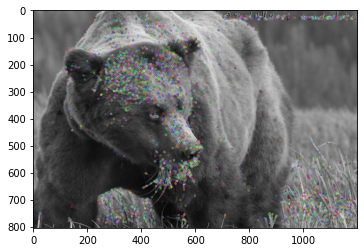

In [42]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

#reading image
img1 = cv2.imread('/content/mammals/bear/00000000.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.BRISK_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)

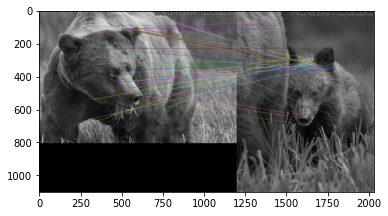

(<matplotlib.image.AxesImage at 0x7f1130311ad0>, None)

In [44]:
# read images
img1 = cv2.imread('/content/mammals/bear/00000000.jpg')  
img2 = cv2.imread('/content/mammals/bear/00000011.jpg') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.BRISK_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()